# Toy example, compare MLP and Ensemble NC

## Generate Data

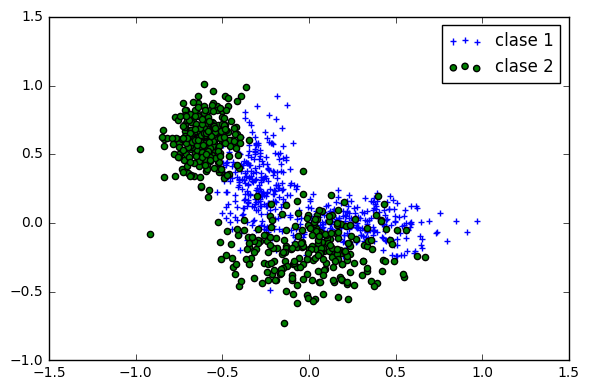

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import scipy
from sklearn import svm
from sklearn import cross_validation
from theano import config

n_class1 = 500
n_class2 = 500

mu_vec11 = np.array([0.3,0])
cov_mat11 = np.array([[0.05,0],[0,0.01]])
x11 = np.random.multivariate_normal(mu_vec11, cov_mat11, n_class1 // 2)

mu_vec12 = np.array([-0.3,0.3])
cov_mat12 = np.array([[0.01,0],[0,0.05]])
x12 = np.random.multivariate_normal(mu_vec12, cov_mat12, n_class1 // 2)

x1_samples = np.concatenate((x11, x12))

mu_vec21 = np.array([-0.6,0.6])
cov_mat21 = np.array([[0.01,0],[0,0.02]])
x21 = np.random.multivariate_normal(mu_vec21, cov_mat21, n_class2 // 2)

mu_vec22 = np.array([0,-0.2])
cov_mat22 = np.array([[0.06,0],[0,0.03]])
x22 = np.random.multivariate_normal(mu_vec22, cov_mat22, n_class2 // 2)

x2_samples = np.concatenate((x21, x22))

fig = plt.figure()

plt.scatter(x1_samples[:,0],x1_samples[:,1], marker='+')
plt.scatter(x2_samples[:,0],x2_samples[:,1], c= 'green', marker='o')

X = np.array(np.concatenate((x1_samples,x2_samples), axis = 0), dtype=config.floatX)
Y = np.array([0]*n_class1 + [1]*n_class2, dtype=config.floatX)
classes_names = [0, 1]
labels = ['clase 1', 'clase 2']

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, Y, test_size=0.4, random_state=0)

X_train = np.array(X_train, dtype=config.floatX)
X_test = np.array(X_test, dtype=config.floatX)
y_train = np.array(y_train, dtype=config.floatX)
y_test = np.array(y_test, dtype=config.floatX)

plt.legend(labels)
plt.tight_layout()

## Training MLP

In [2]:
import os
import sys

sys.path.insert(0, os.path.abspath('../..'))

from deepensemble.models.sequential import Sequential
from deepensemble.layers.dense import Dense
from deepensemble.utils import *
from deepensemble.metrics import *
import theano.tensor as T
from theano import shared
from deepensemble.utils.utils_models import get_ensemble_model, get_ensembleCIP_model, \
    get_ensembleNCL_model, get_mlp_model, get_ensembleCIP_KL_model

# create MLP
mlp = get_mlp_model("MLP (%d neuronas)" % 9,
                           n_input=X.shape[1], n_output=2,
                           n_neurons=15,
                           classification=True,
                           classes_labels=classes_names,
                           fn_activation1=ActivationFunctions.tanh, fn_activation2=ActivationFunctions.sigmoid,
                           cost=cip_relevancy, name_cost="Relevancy", params_cost={'dist': 'CS'}, params_update={'learning_rate': 0.1})
                           # cost=kullback_leibler_generalized, name_cost="KLG", params_update={'learning_rate': 0.1})
                           
mlp.compile(fast=True)

max_epoch = 500  # max epoch training

metric_mlp = mlp.fit(X_train, y_train, max_epoch=max_epoch, batch_size=32, early_stop=False)

metric_mlp.append_prediction(X_test, y_test, append_last_pred=True)

metric_mlp.classification_report()

Start Compile MLP (9 neuronas)  - elapsed: 4.64 [s]
MLP (9 neuronas) - fold: 1, epoch:[####################] 500/500 elapsed: 5.37[s] - left: 0.00[s] | score: 0.5078 / 0.4688
Classification Report:
----------------------------------------------------------------------------
           Precision  Recall     f1 Score   Support    
----------------------------------------------------------------------------
0          52.02 +-0.00      100.00 +-0.00     68.44 +-0.00      206               
1          100.00 +-0.00     2.06 +-0.00       4.04 +-0.00       194               
----------------------------------------------------------------------------
average:   75.29 +-0.00      52.50 +-0.00      37.21 +-0.00      
----------------------------------------------------------------------------



## Training Ensemble

In [3]:
from deepensemble.models.ensemblemodel import EnsembleModel
from deepensemble.combiner import *

# Silverman
s = ITLFunctions.silverman(shared(np.array(y_train)), len(y_train), len(classes_names)).eval()
print('Silverman: %.4g' % s)

# create ensemble
ensemble = get_ensembleCIP_model(name='Ensamble CIP',
                                n_input=X.shape[1], n_output=2,
                                n_ensemble_models=3, n_neurons_models=5,
                                classification=True,
                                is_cip_full=True,
                                classes_labels=classes_names,
                                fn_activation1=ActivationFunctions.tanh, fn_activation2=ActivationFunctions.sigmoid,
                                dist='CS-CIP',
                                beta=0.3, lamb=0.0, s=s, bias_layer=False, mse_first_epoch=True, lr=0.1,
                                params_update={'learning_rate': 0.1})

ensemble.compile(fast=True)

metrics_ensemble = ensemble.fit(X_train, y_train, max_epoch=max_epoch, batch_size=32, early_stop=False)

metrics_ensemble.append_prediction(X_test, y_test, append_last_pred=True)

metrics_ensemble.classification_report()

Silverman: 0.1658
Start Compile Ensamble CIP  - elapsed: 5.04 [s]
Ensamble CIP - fold: 1, epoch:[####################] 500/500 elapsed: 9.55[s] - left: 0.00[s] | score: 0.6230 / 0.5000
Classification Report:
----------------------------------------------------------------------------
           Precision  Recall     f1 Score   Support    
----------------------------------------------------------------------------
0          55.38 +-0.00      50.00 +-0.00      52.55 +-0.00      206               
1          51.87 +-0.00      57.22 +-0.00      54.41 +-0.00      194               
----------------------------------------------------------------------------
average:   53.68 +-0.00      53.50 +-0.00      53.45 +-0.00      
----------------------------------------------------------------------------



## Plot MLP vs Ensemble

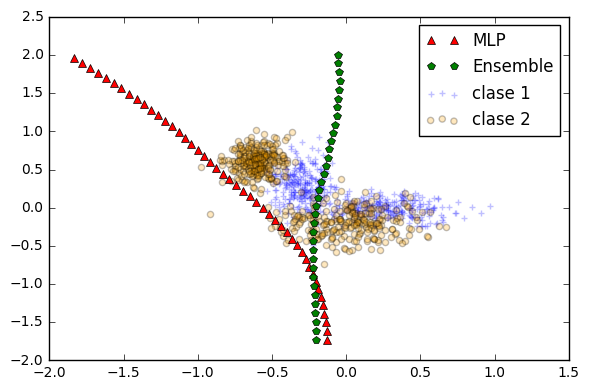

In [4]:
import matplotlib._cntr as cntr

h = .004  # step size in the mesh
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
x = np.array(np.c_[xx.ravel(), yy.ravel()], dtype=config.floatX)
Z1 = mlp.predict(x)
Z2 = ensemble.predict(x)

# Put the result into a color plot
z1 = Z1.reshape(xx.shape)
z2 = Z2.reshape(xx.shape)

def get_contour(x, y, z):
    c = cntr.Cntr(x, y, z)
    level = 0.5
    nlist = c.trace(level, level, 0)
    segs = nlist[:len(nlist)//2]
    x1 = []
    y1 = []
    for seg in segs:
        x1 = np.concatenate((x1, seg[:,0]))
        y1 = np.concatenate((y1, seg[:,1]))
    return x1, y1


xx1, yy1 = get_contour(xx, yy, z1)
xx2, yy2 = get_contour(xx, yy, z2)

fig = plt.figure()
nm = 30
plt.plot(xx1[0::nm], yy1[0::nm], '^r', linewidth=2)
plt.plot(xx2[0::nm], yy2[0::nm], 'pg', linewidth=2)
plt.scatter(x1_samples[:,0],x1_samples[:,1], marker='+', alpha=0.25)
plt.scatter(x2_samples[:,0],x2_samples[:,1], c='orange', marker='o', alpha=0.25)
plt.legend(['MLP', 'Ensemble'] + labels)
plt.tight_layout()

## Plot Models Ensemble

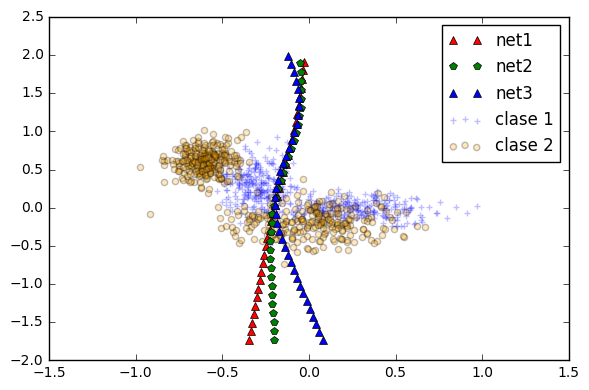

In [5]:

Z21 = ensemble.get_models()[0].predict(x)
Z22 = ensemble.get_models()[1].predict(x)
Z23 = ensemble.get_models()[2].predict(x)

# Put the result into a color plot
z21 = Z21.reshape(xx.shape)
z22 = Z22.reshape(xx.shape)
z23 = Z23.reshape(xx.shape)

xx21, yy21 = get_contour(xx, yy, z21)
xx22, yy22 = get_contour(xx, yy, z22)
xx23, yy23 = get_contour(xx, yy, z23)

fig = plt.figure()
plt.plot(xx21[0::nm], yy21[0::nm], '^r', linewidth=2)
plt.plot(xx22[0::nm], yy22[0::nm], 'pg', linewidth=2)
plt.plot(xx23[0::nm], yy23[0::nm], '^b', linewidth=2)
plt.scatter(x1_samples[:,0],x1_samples[:,1], marker='+', alpha=0.25)
plt.scatter(x2_samples[:,0],x2_samples[:,1], c='orange', marker='o', alpha=0.25)
plt.legend(['net1', 'net2', 'net3'] + labels)
plt.tight_layout()

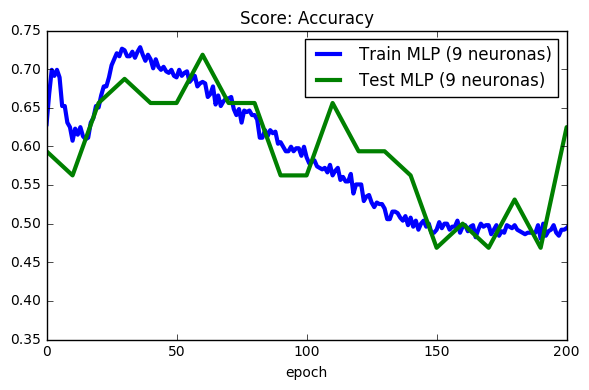

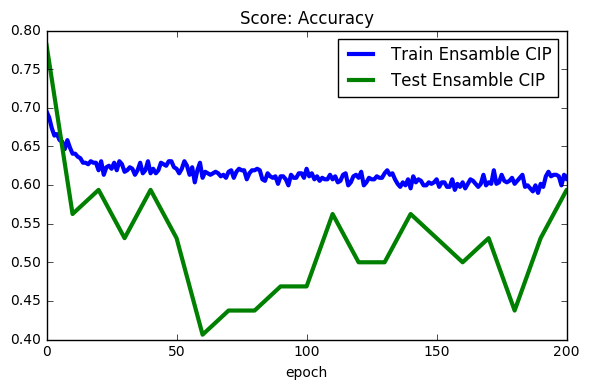

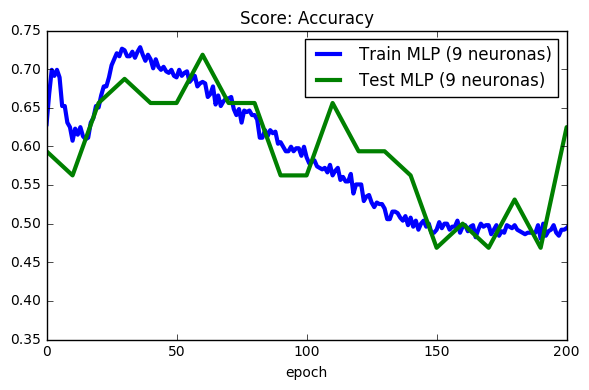

In [6]:
metrics_ensemble.plot_scores(max_epoch=200)
metric_mlp.plot_scores(max_epoch=200)

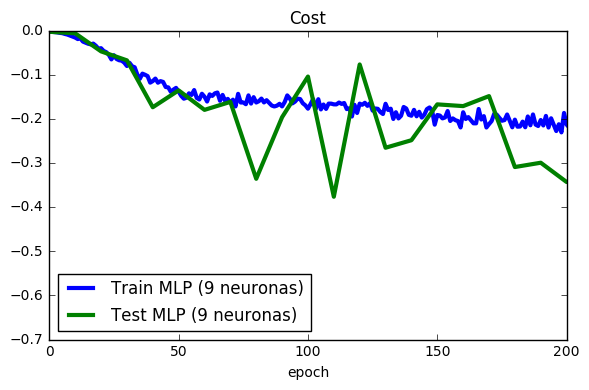

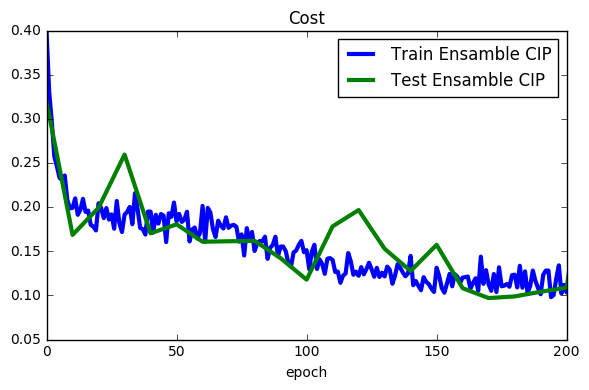

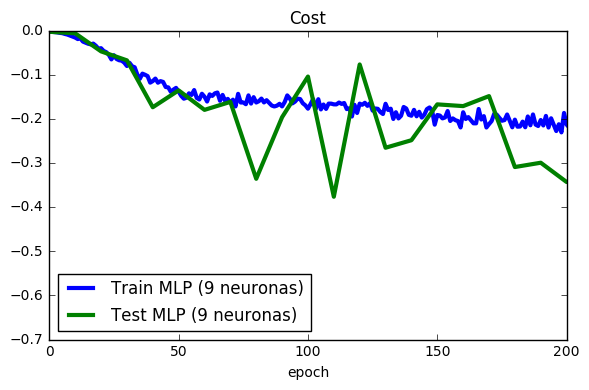

In [7]:
metrics_ensemble.plot_cost(max_epoch=200)
metric_mlp.plot_cost(max_epoch=200)